# Deep Convolutional Generative Adversarial Networks

:label:`chapter_dcgan`


In :numref:`chapter_basic_gan`, we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some data set. And while our example of matching a 2D Gaussian distribution got the point across, it's not especially exciting.

In this section, we'll demonstrate how you can use GANs to generate photorealistic images. We'll be basing our models on the deep convolutional GANs (DCGAN) introduced in :cite:`Radford.Metz.Chintala.2015`. We'll borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.

In [1]:
from mxnet import nd, gluon, autograd, init
from mxnet.gluon import nn
import d2l
import zipfile
import numpy as np

## The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.

In [2]:
data_dir = '../data/'
url = 'http://data.mxnet.io/data/pokemon.zip'
sha1 = 'c065c0e2593b8b161a2d7873e42418bf6a21106c'
fname = gluon.utils.download(url, data_dir, sha1_hash=sha1)
with zipfile.ZipFile(fname) as f:
    f.extractall(data_dir)
pokemon = gluon.data.vision.datasets.ImageFolderDataset(data_dir+'pokemon')

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0,1]$, while our generator will use the tanh function to obtain outputs in $[-1,1]$. Therefore we normalize the data with $1/2$ mean and $1/2$ variance to match the value range.

In [3]:
batch_size = 256
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)
])
data_iter = gluon.data.DataLoader(
    pokemon.transform_first(transformer), batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

Let's visualize the first 20 images.

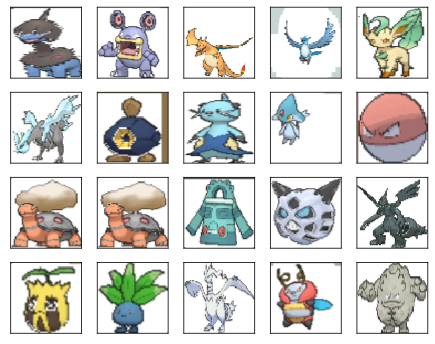

In [4]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].transpose((0,2,3,1))/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

## The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with both width and height to be 64. In :numref:`chapter_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`chapter_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.

In [5]:
class G_block(nn.Block):
    def __init__(self, channels, kernel_size=4,
                 strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $4\times 4$ kernel, $2\times 2$ strides and $1\times 1$ padding. It will double input's width and height.

In [6]:
x = nd.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk.initialize()
g_blk(x).shape

(2, 20, 32, 32)

Changing strides to $1$ and padding to $0$ will lead to increase both input's width and height by 3.

In [7]:
x = nd.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk.initialize()
g_blk(x).shape

(2, 20, 4, 4)

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [8]:
n_G = 64
net_G = nn.Sequential()
net_G.add(G_block(n_G*8, strides=1, padding=0),  # output: (64*8, 4, 4)
          G_block(n_G*4),  # output: (64*4, 8, 8)
          G_block(n_G*2),  # output: (64*2, 16, 16)
          G_block(n_G),    # output: (64, 32, 32)
          nn.Conv2DTranspose(
              3, kernel_size=4, strides=2, padding=1, use_bias=False,
              activation='tanh'))  # output: (3, 64, 64)

Generate a 100 dimensional latent variable to verify the generator's output shape.

In [9]:
x = nd.zeros((1, 100, 1, 1))
net_G.initialize()
net_G(x).shape

(1, 3, 64, 64)

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0,1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0,1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

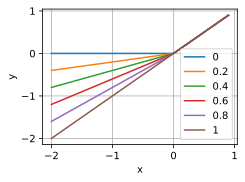

In [10]:
alphas = [0, 0.2, 0.4, .6, .8, 1]
x = nd.arange(-2,1,0.1)
Y = [nn.LeakyReLU(alpha)(x).asnumpy() for alpha in alphas]
d2l.plot(x.asnumpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyper-parameters of the convolution layer are similar to the transpose convolution layer in the generator block.

In [11]:
class D_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block will halve the width and height of the inputs.

In [12]:
x = nd.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk.initialize()
d_blk(x).shape

(2, 20, 8, 8)

The discriminator is a mirror of the generator.

In [13]:
n_D = 64
net_D = nn.Sequential()
net_D.add(D_block(n_D),    # output: (64, 32, 32)
          D_block(n_D*2),  # output: (64*2, 16, 16)
          D_block(n_D*4),  # output: (64*4, 8, 8)
          D_block(n_D*8),  # output: (64*8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # output: (1, 1, 1)

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.

In [14]:
x = nd.zeros((1, 3, 64, 64))
net_D.initialize()
net_D(x).shape

(1, 1, 1, 1)

## Training

Compared to the basic GAN in :numref:`chapter_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`chapter_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, `Z` is a 4-D tensor and we are using GPU to accelerate the computation.

In [15]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          ctx=d2l.try_gpu()):
    loss = gluon.loss.SigmoidBCELoss()
    net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=ctx)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=ctx)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', trainer_hp)
    trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5,5),
                            legend=['generator', 'discriminator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs+1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = nd.random.normal(0, 1, shape=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_context(ctx), Z.as_in_context(ctx),
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                        d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                        batch_size)
        # Show generated examples
        Z = nd.random.normal(0, 1, shape=(21, latent_dim, 1, 1), ctx=ctx)
        fake_x = (net_G(Z).transpose((0,2,3,1))/2+0.5).asnumpy()
        imgs = np.vstack([np.hstack(fake_x[i:i+7])
                          for i in range(0,len(fake_x),7)])
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print('loss_D %.3f, loss_G %.3f, %d examples/sec on %s' % (
        loss_D, loss_G, metric[2]/timer.stop(), ctx))


Now let's train the model.

loss_D 0.015, loss_G 6.629, 2587 examples/sec on gpu(0)


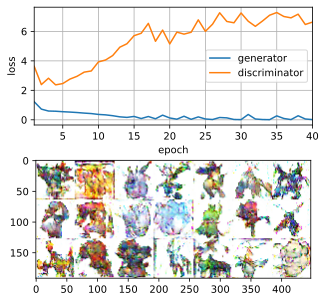

In [16]:
latent_dim, lr, num_epochs = 100, 0.005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## Summary